In [128]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [129]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf
import qutip as qt
from matplotlib import pyplot as plt

We also declare a 3-qubit simulator device running in Cirq.


In [130]:
dev = qml.device('cirq.simulator', wires=3)

Generator and Discriminator
===========================




In [145]:

def generator(w):
    #qml.Hadamard(wires=0)
    qml.RY(w[0],wires = 1)
    qml.CNOT(wires = [1,2])
    qml.RX(w[1],wires = 1)
    qml.RZ(w[2],wires = 1)
    
def U1(w,wire):
    qml.RZ(w[0],wires = wire)
    qml.RX(w[1],wires = wire)
    qml.RZ(w[2],wires = wire)  
    
def discriminator(w):
    qml.CNOT(wires = [1,0])
    qml.RY(w[0],wires = 1)
    qml.CNOT(wires = [0,1])
    qml.RY(w[1],wires = 1)
    qml.CNOT(wires = [1,0])
    qml.RZ(w[2], wires = 0)
    qml.RX(w[3], wires = 0)
    
def real(w):
    qml.RY(w[0],wires = 1)
    qml.CNOT(wires = [1,2])
    qml.RX(w[1],wires = 1)
    qml.RZ(w[2],wires = 1)

# Nodes

In [132]:
@qml.qnode(dev, diff_method="parameter-shift")
def real_disc_circuit(real_params, disc_weights):
    real(real_params)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(0))

@qml.qnode(dev, diff_method="parameter-shift")
def gen_disc_circuit(gen_weights, disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(0))



QGAN cost functions
===================




In [133]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(real_params, disc_weights)
    # convert to probability
    prob_real_true = (true_disc_output + 1) / 2
    return prob_real_true


def prob_fake_true(gen_weights, disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights, disc_weights)
    # convert to probability
    prob_fake_true = (fake_disc_output + 1) / 2
    return prob_fake_true


def disc_cost(disc_weights, gen_weights):
    cost = prob_fake_true(gen_weights, disc_weights) - prob_real_true(disc_weights)
    return cost


def gen_cost(gen_weights, disc_weights):
    cost = -prob_fake_true(gen_weights, disc_weights)
    return cost

Initializing the weights
=================


Real state generation

In [134]:
np.random.seed(1)
real_params = np.random.uniform(low=-np.pi, high=np.pi, size=3)

Generator and Discriminator parameter initialization

In [135]:
np.random.seed(17)
init_gen_weights = np.random.uniform(low=-np.pi, high=np.pi, size=3)
np.random.seed(17)
init_disc_weights = np.random.uniform(low=-np.pi, high=np.pi, size=4)

gen_weights=np.array(list(init_gen_weights), requires_grad=False)
disc_weights=np.array(list(init_disc_weights), requires_grad=True)

We begin by creating the optimizer:


We train in turns. We expect around 250 turns to converge. Each turn consists of 5 discriminator steps and 1 generator step.

# Define some other metrics

In [136]:
dev_state = qml.device('default.qubit', wires=3)

In [137]:
@qml.qnode(dev_state, interface="tf")
def real_circuit(w):
    real(w)
    return qml.density_matrix([1])


@qml.qnode(dev_state, interface="tf")
def gen_circuit(gen_weights):
    generator(gen_weights)
    return qml.density_matrix([1])

In [138]:
def F_Tr_state(real_params,gen_weights):
    real_state = qt.Qobj(real_circuit(real_params).numpy())
    gen_state = qt.Qobj(gen_circuit(gen_weights).numpy())
    
    F = qt.fidelity(real_state,gen_state)
    d = qt.tracedist(real_state,gen_state)
    
    return (F,d,real_state,gen_state)

Visualize the real state, let's see if it's mixed

In [139]:
real_state = qt.Qobj(real_circuit(real_params).numpy())
(real_state*real_state).tr()

0.8759655184579888

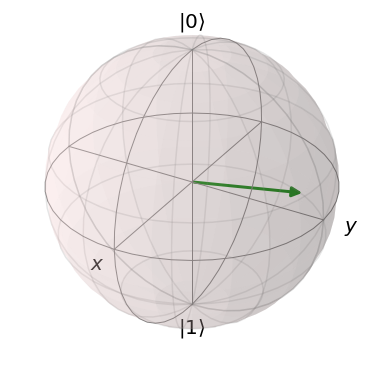

In [140]:
b = qt.Bloch()

b.add_states(real_state)
b.render()

In [141]:
import warnings

from pennylane._grad import grad as get_gradient
from pennylane.utils import _flatten, unflatten
from pennylane.numpy import ndarray, tensor


class MirrorDescentOptimizer:
    r"""Basic mirror-descent optimizer.
    Base class for other gradient-descent-based optimizers.
    A step of the mirror descent optimizer computes the new values via the rule
    .. math::
        x^{(t+1)} = x^{(t)} - 2*\eta \nabla f(x^{(t)}). + \eta \nabla f(x^{(t-1)})
    where :math:`\eta` is a user-defined hyperparameter corresponding to step size.
    Args:
        stepsize (float): the user-defined hyperparameter :math:`\eta`
    """

    def __init__(self, stepsize=0.01):
        self.stepsize = stepsize
        

    def apply_grad(self, grad_t, grad_t_prev, args):
        r"""Update the variables to take a single optimization step. 
        Args:
            grad_t & grad_t_pref (tuple [array]): the current and previous gradient of the objective
                function 
            args (tuple): the current value of the variables :math:`x^{(t)}`
        Returns:
            list [array]: the new values :math:`x^{(t+1)}`
        """
        args_new = list(args)

        trained_index = 0
        for index, arg in enumerate(args):
            if getattr(arg, "requires_grad", True):
                
                args_new[index] = arg - 2* self.stepsize * grad_t[index] + self.stepsize * grad_t_prev[index]

                if isinstance(arg, ndarray):
                    # Due to a bug in unflatten, input PennyLane tensors
                    # are being unwrapped. Here, we cast them back to PennyLane
                    # tensors. 
                    # TODO: remove when the following is fixed:
                    # https://github.com/PennyLaneAI/pennylane/issues/966
                    args_new[index] = args_new[index].view(tensor)
                    args_new[index].requires_grad = True

        return args_new

In [142]:
opt1=MirrorDescentOptimizer(stepsize=0.05)
opt2=MirrorDescentOptimizer(stepsize=0.05)

# Training routine

In [146]:
#----- Metrics ----------------------------

Disc_cost = [] # P(R|R)-P(R|G)
Gen_cost = [] # P(R|G)
Trace_d = [] #Trace distance
F = [] #Fidelity

#-------------------------------------------

costD = lambda: disc_cost(disc_weights, gen_weights)
costG = lambda: gen_cost(gen_weights, disc_weights)

for turn in range(250):

    disc_weights=np.array(list(disc_weights), requires_grad=True)
    gen_weights=np.array(list(gen_weights), requires_grad=False)
    
    for step in range(10): #The actual ratio should be 20 to 1, according to what we discussed
        
        grad_gen_circuit_disc=qml.grad(gen_disc_circuit, argnum=1)
        grad_real_disc_circuit=qml.grad(real_disc_circuit, argnum=1) 
        grad_disc_current=grad_gen_circuit_disc(gen_weights, disc_weights)-grad_real_disc_circuit(real_params, disc_weights)
        
        if step == 0:
            #if we are in the first step, do normal gradient descent because there is no history of gradients
            grad_disc_prev = grad_disc_current
        
        #apply the optimization step
        disc_weights=np.array(opt1.apply_grad(grad_disc_current, grad_disc_prev, disc_weights), requires_grad=True)
        
        #new gradient becomes old one
        grad_disc_prev = grad_disc_current

        if step == 9:
            costD_val = costD().numpy()
            Disc_cost += [-costD_val] # P(R|R)-P(R|G)

    disc_weights=np.array(list(disc_weights), requires_grad=False)
    gen_weights=np.array(list(gen_weights), requires_grad=True)

    grad_gen_current=-qml.grad(gen_disc_circuit, argnum=0)(gen_weights, disc_weights)
    
    #generator has only one optimization step --> no history
    grad_gen_prev = grad_gen_current
    
    #do optimization step
    gen_weights=np.array(opt2.apply_grad(grad_gen_current, grad_gen_prev, gen_weights), requires_grad=True)
    
    grad_gen_prev = grad_gen_current
   
    costG_val = costG().numpy()
    Gen_cost += [-costG_val] # P(R|G)
    
 

    F_Tr_st = F_Tr_state(real_params,gen_weights)
    
    
    F += [F_Tr_st[0]] #Fidelity
    Trace_d += [F_Tr_st[1]] #Trace distance
    States += [F_Tr_st[3]]
    
    print("P(R|R)-P(R|G): ", -costD_val)
    print("P(R|G): ", -costG_val)
    print("Fidelity: ",F_Tr_st[0])
    print("Trace distance: ",F_Tr_st[1])
    print("------------------------------")

P(R|R)-P(R|G):  0.13555239140987396
P(R|G):  0.39576561748981476
Fidelity:  0.8768061002881342
Trace distance:  0.4205139463711247
------------------------------
P(R|R)-P(R|G):  0.21214133501052856
P(R|G):  0.418515682220459
Fidelity:  0.8765399999895556
Trace distance:  0.4201604689701196
------------------------------
P(R|R)-P(R|G):  0.2899733781814575
P(R|G):  0.4441438615322113
Fidelity:  0.8763215189855049
Trace distance:  0.41989260573084153
------------------------------
P(R|R)-P(R|G):  0.34884658455848694
P(R|G):  0.46584954857826233
Fidelity:  0.8761809788172978
Trace distance:  0.41968301156091764
------------------------------
P(R|R)-P(R|G):  0.3840915486216545
P(R|G):  0.4810144007205963
Fidelity:  0.876121685058688
Trace distance:  0.4195006301876567
------------------------------
P(R|R)-P(R|G):  0.40226226300001144
P(R|G):  0.49065259099006653
Fidelity:  0.8761314894887252
Trace distance:  0.4193253664344703
------------------------------
P(R|R)-P(R|G):  0.410850420594215

P(R|R)-P(R|G):  0.386901430785656
P(R|G):  0.5219845473766327
Fidelity:  0.8946247678726023
Trace distance:  0.3945566906300899
------------------------------
P(R|R)-P(R|G):  0.3856043368577957
P(R|G):  0.5221400856971741
Fidelity:  0.8954523051421752
Trace distance:  0.3931759853079333
------------------------------
P(R|R)-P(R|G):  0.38427333161234856
P(R|G):  0.5222684890031815
Fidelity:  0.8963071535829912
Trace distance:  0.3917245062957867
------------------------------
P(R|R)-P(R|G):  0.3829065077006817
P(R|G):  0.5223726332187653
Fidelity:  0.8971898043703918
Trace distance:  0.3901995081383383
------------------------------
P(R|R)-P(R|G):  0.38150105625391006
P(R|G):  0.5224566608667374
Fidelity:  0.8981007462457713
Trace distance:  0.3885982709291271
------------------------------
P(R|R)-P(R|G):  0.38005416095256805
P(R|G):  0.5225259065628052
Fidelity:  0.8990404743796837
Trace distance:  0.3869181032792125
------------------------------
P(R|R)-P(R|G):  0.37856176495552063
P(

P(R|R)-P(R|G):  0.1372533068060875
P(R|G):  0.6784558147192001
Fidelity:  0.9875673036693025
Trace distance:  0.12570563959820807
------------------------------
P(R|R)-P(R|G):  0.12537892907857895
P(R|G):  0.6887801885604858
Fidelity:  0.9896064195854124
Trace distance:  0.11351859164255461
------------------------------
P(R|R)-P(R|G):  0.11322087794542313
P(R|G):  0.6996597349643707
Fidelity:  0.9915006952819807
Trace distance:  0.10107776837726049
------------------------------
P(R|R)-P(R|G):  0.10081259906291962
P(R|G):  0.7111231982707977
Fidelity:  0.9932324182877292
Trace distance:  0.08843196258950103
------------------------------
P(R|R)-P(R|G):  0.08819679170846939
P(R|G):  0.7231994420289993
Fidelity:  0.994784404272511
Trace distance:  0.07565003832827367
------------------------------
P(R|R)-P(R|G):  0.0754261389374733
P(R|G):  0.7359171807765961
Fidelity:  0.9961404426166127
Trace distance:  0.06283555702605603
------------------------------
P(R|R)-P(R|G):  0.0625655800104

P(R|R)-P(R|G):  -0.0332428403198719
P(R|G):  0.939483854919672
Fidelity:  0.97498019879084
Trace distance:  0.08463771432819225
------------------------------
P(R|R)-P(R|G):  -0.03338412940502167
P(R|G):  0.9286152385175228
Fidelity:  0.9750922307216695
Trace distance:  0.0786613651249
------------------------------
P(R|R)-P(R|G):  -0.03562065586447716
P(R|G):  0.9194236472249031
Fidelity:  0.9751137441514945
Trace distance:  0.07369723135201509
------------------------------
P(R|R)-P(R|G):  -0.03971308469772339
P(R|G):  0.9124058708548546
Fidelity:  0.9750092726479805
Trace distance:  0.07040883068627549
------------------------------
P(R|R)-P(R|G):  -0.045339345932006836
P(R|G):  0.907857421785593
Fidelity:  0.9747530416036886
Trace distance:  0.06935375066566882
------------------------------
P(R|R)-P(R|G):  -0.0521341897547245
P(R|G):  0.9059137925505638
Fidelity:  0.9743295432278526
Trace distance:  0.07080334600394259
------------------------------
P(R|R)-P(R|G):  -0.059708811342

P(R|R)-P(R|G):  -0.03950604796409607
P(R|G):  0.8874672465026379
Fidelity:  0.9647886357647767
Trace distance:  0.09732859460899007
------------------------------
P(R|R)-P(R|G):  -0.042855843901634216
P(R|G):  0.8810322098433971
Fidelity:  0.9648807319997799
Trace distance:  0.09597152234637986
------------------------------
P(R|R)-P(R|G):  -0.04726911336183548
P(R|G):  0.8759929239749908
Fidelity:  0.9648319610722685
Trace distance:  0.09604328118367547
------------------------------
P(R|R)-P(R|G):  -0.052535757422447205
P(R|G):  0.8725733011960983
Fidelity:  0.9646328941250345
Trace distance:  0.09763058184149925
------------------------------
P(R|R)-P(R|G):  -0.0583990141749382
P(R|G):  0.8709384575486183
Fidelity:  0.9642818244708903
Trace distance:  0.10067431030468449
------------------------------
P(R|R)-P(R|G):  -0.06455915421247482
P(R|G):  0.8711585700511932
Fidelity:  0.9637853410701783
Trace distance:  0.10498344139286755
------------------------------
P(R|R)-P(R|G):  -0.07

KeyboardInterrupt: 

In [147]:
F = np.array(F)
Gen_cost = np.array(Gen_cost)
Disc_cost = np.array(Disc_cost)
Trace_d = np.array(Trace_d)

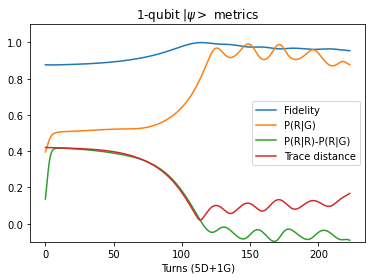

In [148]:
plt.plot(F, label='Fidelity')
plt.plot(Gen_cost, label='P(R|G)')
plt.plot(Disc_cost, label='P(R|R)-P(R|G)')
plt.plot(Trace_d, label='Trace distance')
plt.ylim([-0.1,1.1])
plt.xlabel('Turns (5D+1G)') 
plt.title("1-qubit $|\psi>$ metrics")
plt.legend()
plt.savefig('1qubitlearning_parameter_shift.png', format='png')

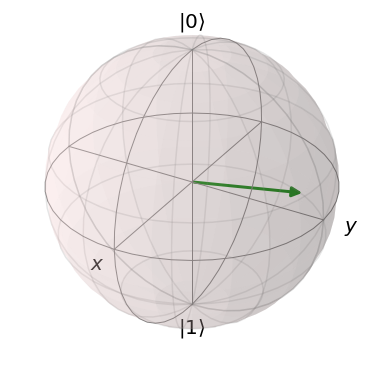

In [149]:
real_state = qt.Qobj(real_circuit(real_params).numpy())
(real_state*real_state).tr()

b = qt.Bloch()

b.add_states(real_state)
b.render()

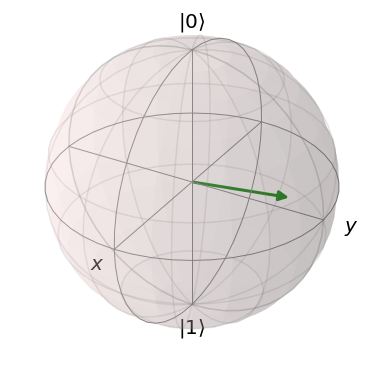

In [150]:
gen_state = qt.Qobj(gen_circuit(gen_weights).numpy())
(gen_state*gen_state).tr()

b = qt.Bloch()

b.add_states(gen_state)
b.render()